<a href="https://colab.research.google.com/github/Ksenia-90/NN/blob/lesson_6/dz_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка библиотек

In [67]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

fatal: destination path 'clothing-co-parsing' already exists and is not an empty directory.


In [68]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
seed = 42
np.random.seed = seed
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

# Проверить устройства для кераса

In [69]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3249607269232169208
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6509159976647413268
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Функции для визуализации

In [70]:
def display(display_list):
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Загрузка датасета и обработка

In [71]:
DATASET_PATH = '/content/clothing-co-parsing/photos/'
MASKS_PATH = '/content/clothing-co-parsing/annotations/pixel-level/'

In [72]:
def preprocess_image(image):
     image = tf.cast(image, tf.float32)
     # scale values to [0,1]
     image = image/255.0
     # resize image
     image = tf.image.resize(image, (128,128))
     return image 
     

def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    # будем использовать бинарную классификацию - фон и человек
    # для этого фон, закодированный нулем, оставим нулевым
    # все остальное будет равно единице
    mask = tf.cast(mask != 0, tf.uint8)
    return mask  

In [73]:
images = []
masks = []

for mask_filename in os.listdir(MASKS_PATH):
  image_filename = mask_filename[:-4] + '.jpg'
  image = img_to_array(load_img(DATASET_PATH + image_filename))
  images.append(preprocess_image(image))
      
  mask_file = io.loadmat(MASKS_PATH + mask_filename)
  mask = tf.convert_to_tensor(mask_file['groundtruth']) 
  masks.append(preprocess_mask(mask))

In [74]:
train_X, test_X, train_Y, test_Y = train_test_split(images, masks,\
                                                 test_size=0.2, random_state=0)
sample_image, sample_mask = train_X[0], train_Y[0]

train_X = tf.data.Dataset.from_tensor_slices(train_X)
test_X = tf.data.Dataset.from_tensor_slices(test_X)
train_Y = tf.data.Dataset.from_tensor_slices(train_Y)
test_Y = tf.data.Dataset.from_tensor_slices(test_Y)

train = tf.data.Dataset.zip((train_X, train_Y))
test = tf.data.Dataset.zip((test_X, test_Y)) 

In [75]:
# функции для аугментации 

# яркость
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# оттенок
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# отзеркаливание по горизонтали
def flip_horisontal(img, mask):
     img = tf.image.flip_left_right(img)
     mask = tf.image.flip_left_right(mask)
     return img, mask

In [76]:
# последовательно применяем аугментации
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horisontal))

In [77]:
len(train)

6424

In [78]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  input_mask = tf.math.round(input_mask)
  return input_image, input_mask

def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [79]:
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE) 

далее обучайте на датасете train, для валидации используйте датасет test аналогично как на занятии

In [80]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False, weights='imagenet', classifier_activation='softmax')

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [81]:
def DeConv2D_block(filters, ksize):
  initializer = tf.random_normal_initializer(0., 0.02)

  model = tf.keras.Sequential()
  model.add(
    tf.keras.layers.Conv2DTranspose(
      filters=filters, kernel_size=ksize, strides=(2, 2), padding="same",
      kernel_initializer=initializer, use_bias=False)
  )
    
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.ReLU())

  return model

In [82]:
up_stack = [
  DeConv2D_block(filters=512, ksize=(3, 3)),  
  DeConv2D_block(filters=256, ksize=(3, 3)),  
  DeConv2D_block(filters=128, ksize=(3, 3)),  
  DeConv2D_block(filters=64, ksize=(3, 3)),   
]

In [84]:
def resolution_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, 
                                         padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [85]:
OUTPUT_CHANNELS = 3

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

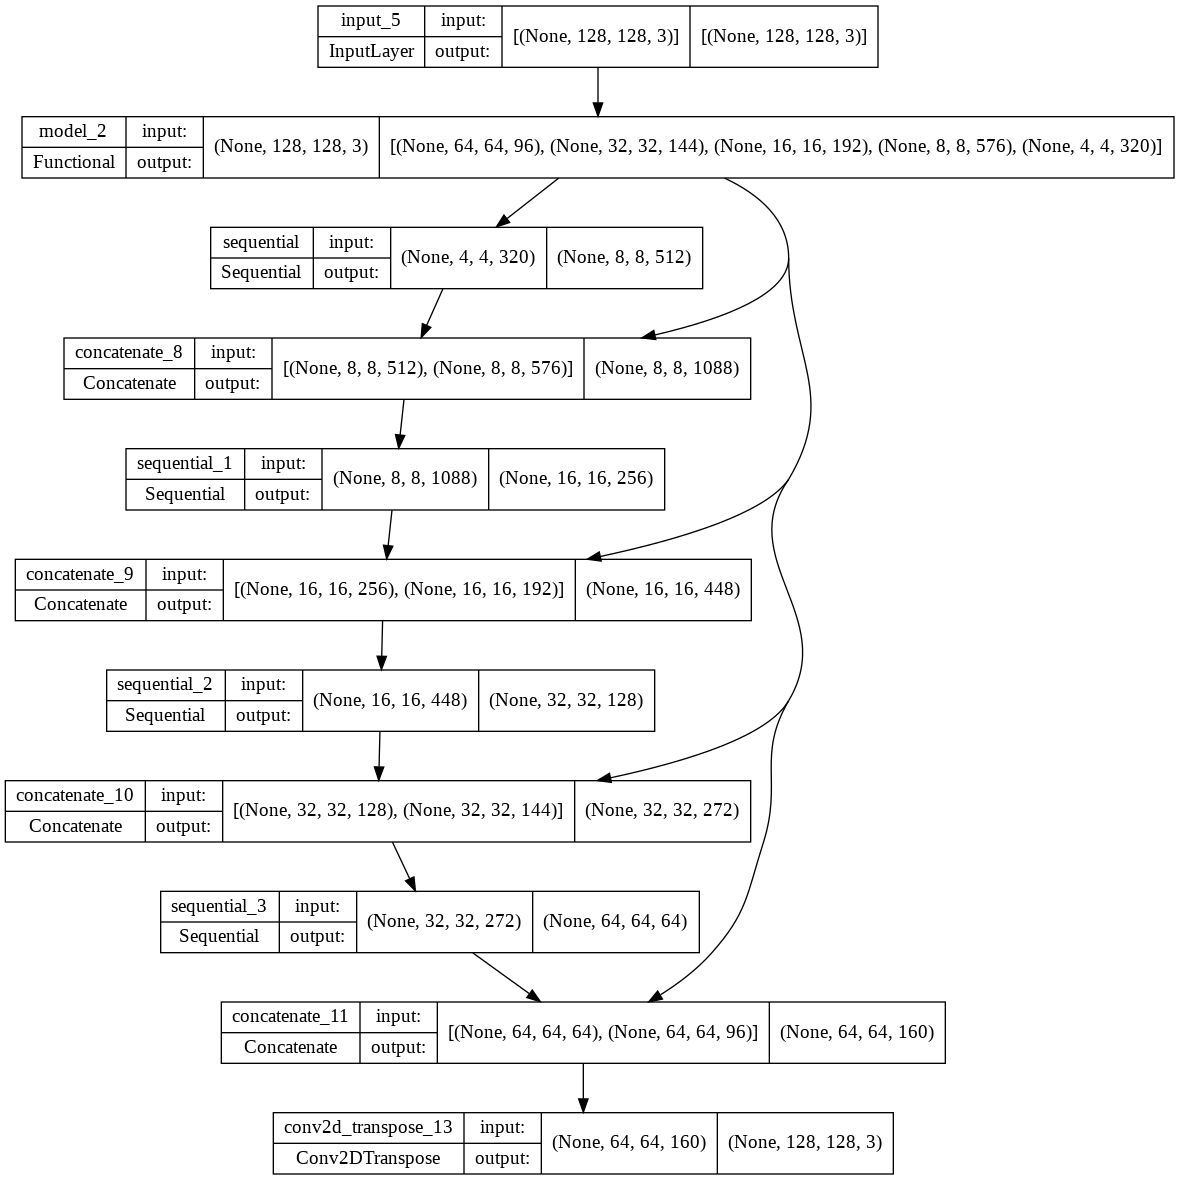

In [86]:
tf.keras.utils.plot_model(model, show_shapes=True)

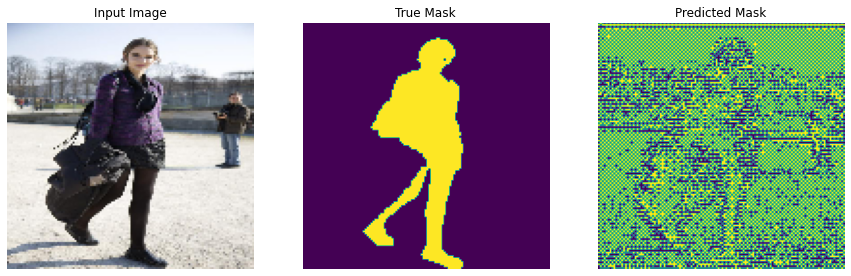

In [87]:
show_predictions(model)

Epoch 1/15
201/201 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9834

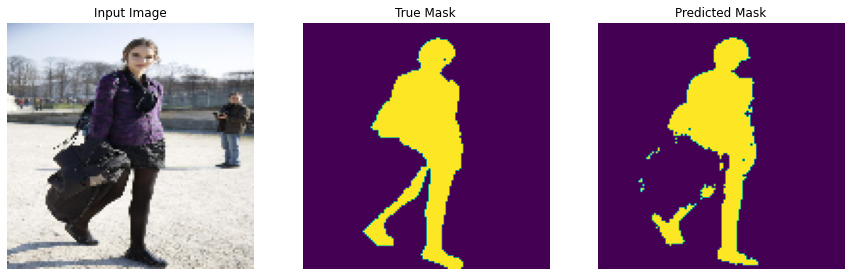


Sample Prediction after epoch 1

201/201 [==============================] - 14s 68ms/step - loss: 0.0445 - accuracy: 0.9834 - val_loss: 0.0681 - val_accuracy: 0.9744
Epoch 2/15
201/201 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9871

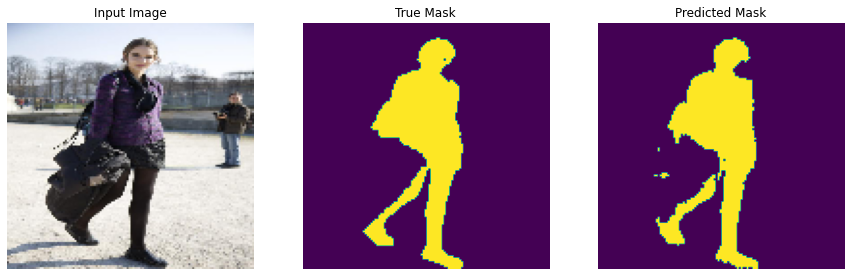


Sample Prediction after epoch 2

201/201 [==============================] - 14s 68ms/step - loss: 0.0338 - accuracy: 0.9871 - val_loss: 0.0683 - val_accuracy: 0.9752
Epoch 3/15
201/201 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9893

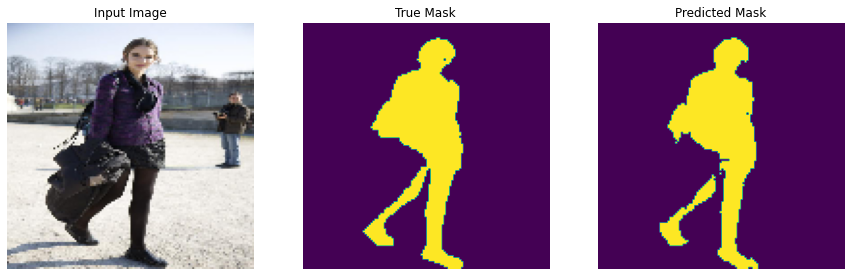


Sample Prediction after epoch 3

201/201 [==============================] - 14s 68ms/step - loss: 0.0276 - accuracy: 0.9893 - val_loss: 0.0718 - val_accuracy: 0.9752
Epoch 4/15
201/201 [==============================] - ETA: 0s - loss: 0.0227 - accuracy: 0.9912

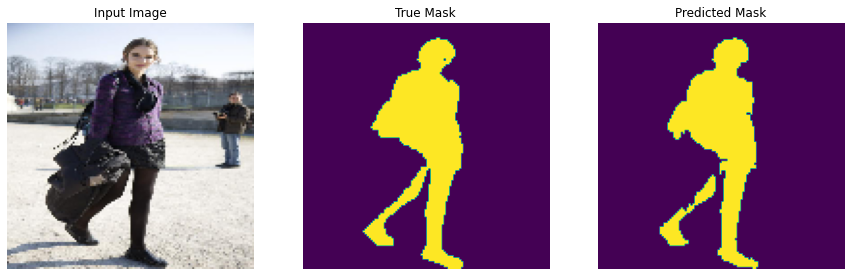


Sample Prediction after epoch 4

201/201 [==============================] - 13s 67ms/step - loss: 0.0227 - accuracy: 0.9912 - val_loss: 0.0744 - val_accuracy: 0.9757
Epoch 5/15
201/201 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9922

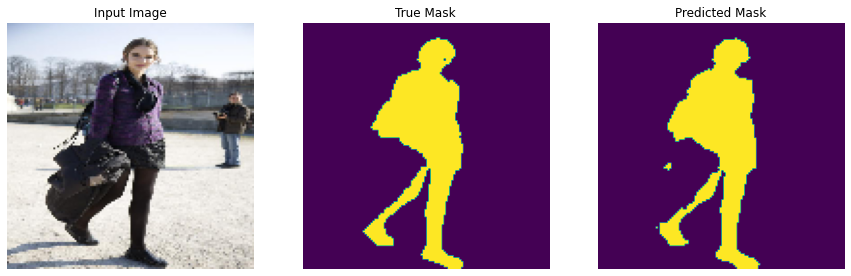


Sample Prediction after epoch 5

201/201 [==============================] - 14s 68ms/step - loss: 0.0199 - accuracy: 0.9922 - val_loss: 0.0773 - val_accuracy: 0.9759
Epoch 6/15
201/201 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9932

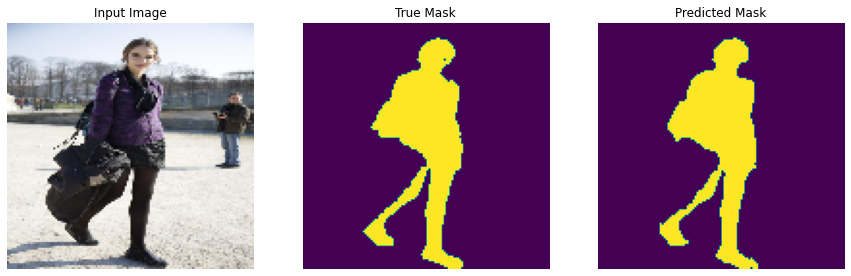


Sample Prediction after epoch 6

201/201 [==============================] - 14s 70ms/step - loss: 0.0175 - accuracy: 0.9932 - val_loss: 0.0826 - val_accuracy: 0.9758
Epoch 7/15
201/201 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9938

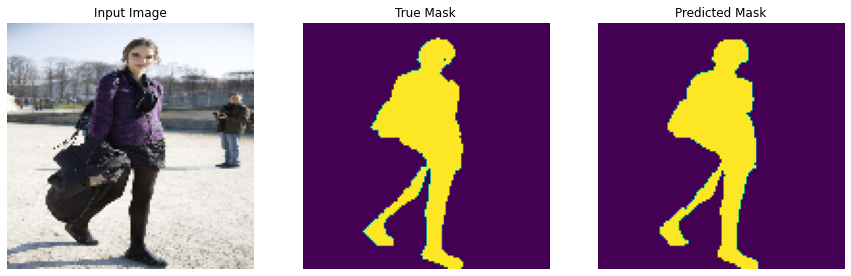


Sample Prediction after epoch 7

201/201 [==============================] - 14s 69ms/step - loss: 0.0159 - accuracy: 0.9938 - val_loss: 0.0833 - val_accuracy: 0.9758
Epoch 8/15
201/201 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9946

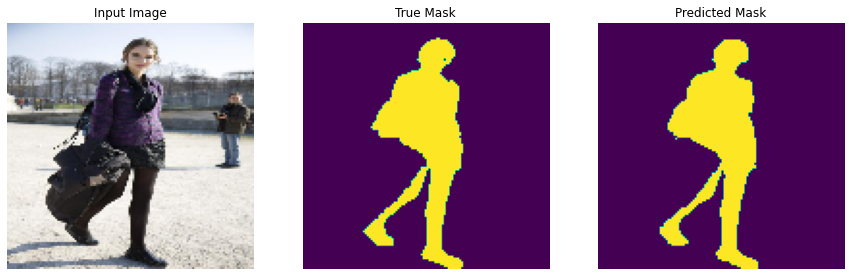


Sample Prediction after epoch 8

201/201 [==============================] - 14s 68ms/step - loss: 0.0139 - accuracy: 0.9946 - val_loss: 0.0886 - val_accuracy: 0.9758
Epoch 9/15
201/201 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9950

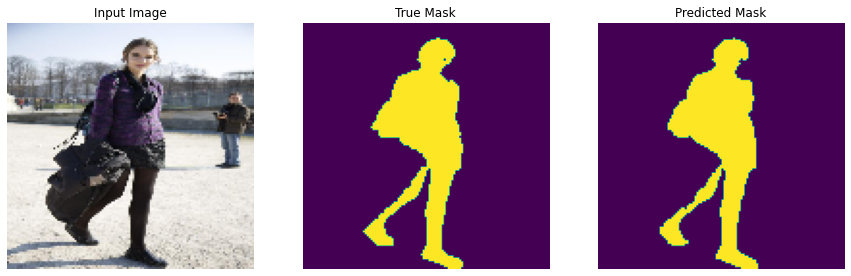


Sample Prediction after epoch 9

201/201 [==============================] - 14s 68ms/step - loss: 0.0130 - accuracy: 0.9950 - val_loss: 0.0908 - val_accuracy: 0.9757
Epoch 10/15
201/201 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9954

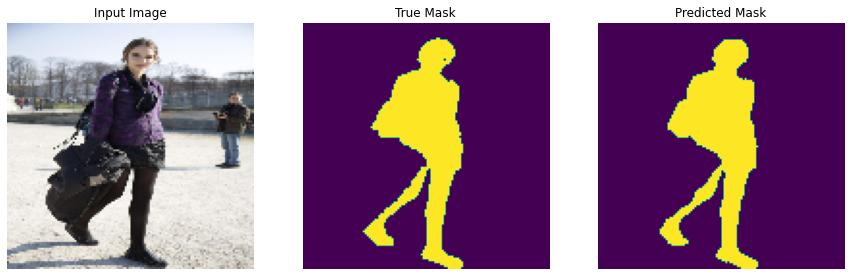


Sample Prediction after epoch 10

201/201 [==============================] - 15s 74ms/step - loss: 0.0120 - accuracy: 0.9954 - val_loss: 0.0962 - val_accuracy: 0.9757
Epoch 11/15
201/201 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9958

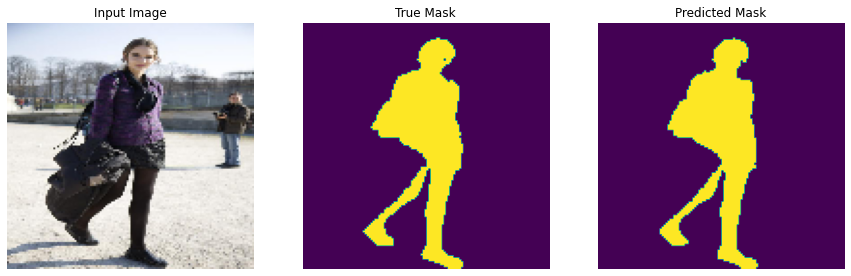


Sample Prediction after epoch 11

201/201 [==============================] - 16s 78ms/step - loss: 0.0108 - accuracy: 0.9958 - val_loss: 0.0989 - val_accuracy: 0.9757
Epoch 12/15
201/201 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9962

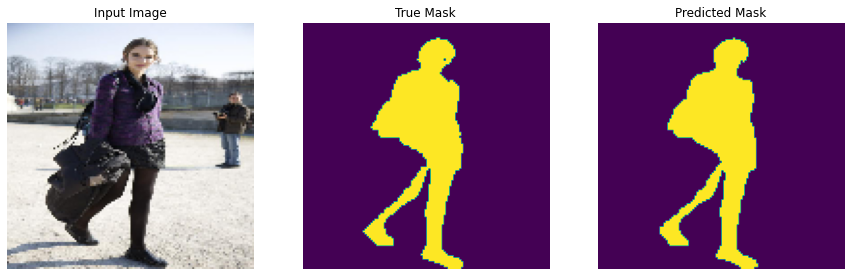


Sample Prediction after epoch 12

201/201 [==============================] - 15s 73ms/step - loss: 0.0098 - accuracy: 0.9962 - val_loss: 0.1014 - val_accuracy: 0.9758
Epoch 13/15
201/201 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9964

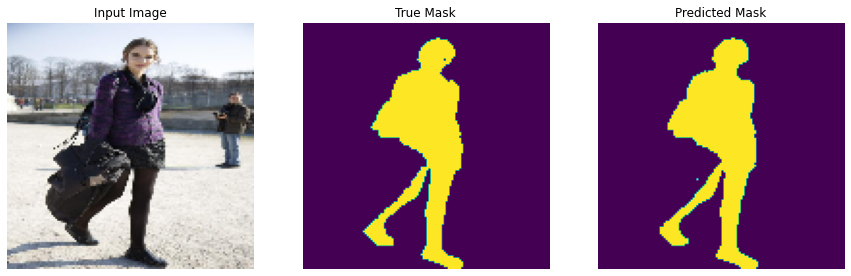


Sample Prediction after epoch 13

201/201 [==============================] - 14s 68ms/step - loss: 0.0095 - accuracy: 0.9964 - val_loss: 0.1052 - val_accuracy: 0.9758
Epoch 14/15
201/201 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9967

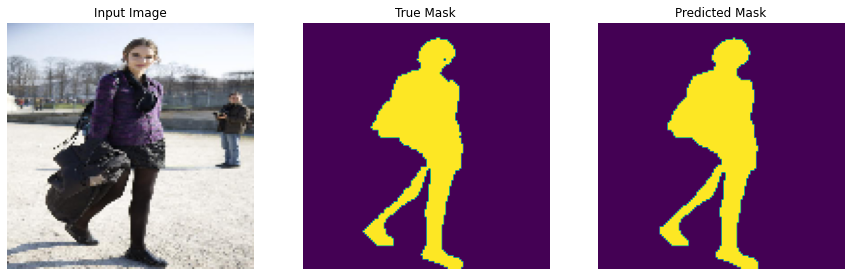


Sample Prediction after epoch 14

201/201 [==============================] - 14s 68ms/step - loss: 0.0086 - accuracy: 0.9967 - val_loss: 0.1098 - val_accuracy: 0.9758
Epoch 15/15
201/201 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9969

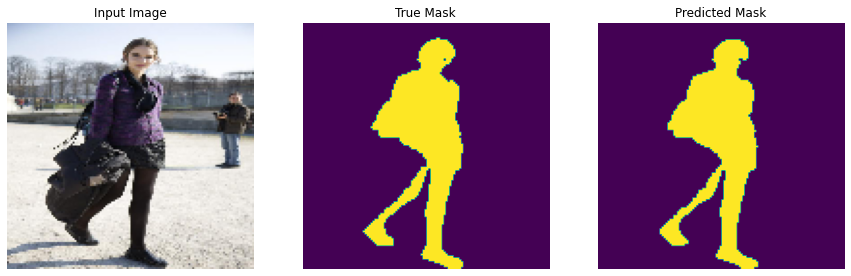


Sample Prediction after epoch 15

201/201 [==============================] - 14s 68ms/step - loss: 0.0082 - accuracy: 0.9969 - val_loss: 0.1104 - val_accuracy: 0.9756


In [89]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions(model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


EPOCHS = 15 # увеличьте при необходимости

model_history = model.fit(train, epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test,
                          callbacks=[DisplayCallback()])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

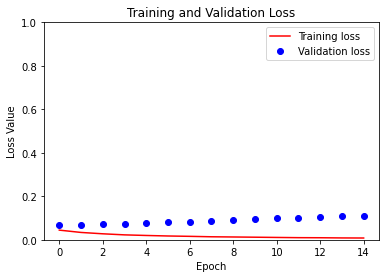

In [90]:
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

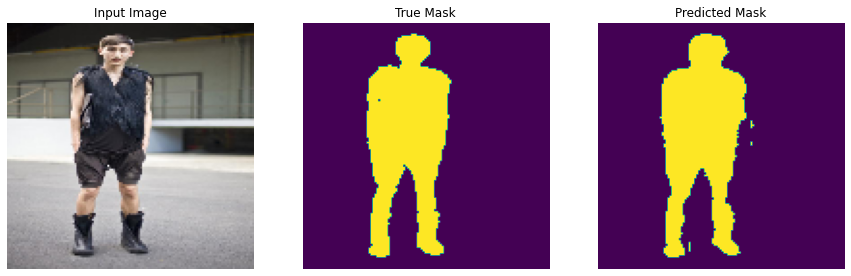

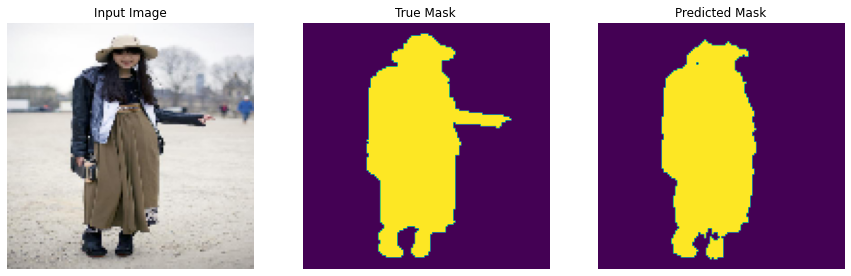

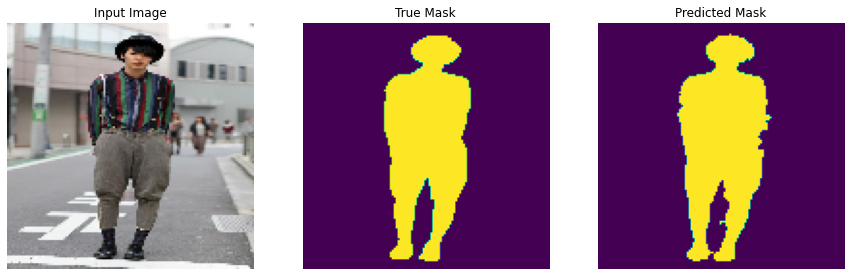

In [91]:
show_predictions(model, test, 3)